In [7]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

ImportError: DLL load failed while importing _multiarray_umath: No se puede encontrar el módulo especificado.

ImportError: numpy._core.multiarray failed to import

# Brute force

In [ ]:
# Pauli matrices
σx = sp.csr_matrix([[0, 1], [1, 0]], dtype=complex)
σy = sp.csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
σz = sp.csr_matrix([[1, 0], [0, -1]], dtype=complex)
σp = (σx + 1j*σy) / 2  # raising
σm = (σx - 1j*σy) / 2  # lowering

def place(op, site, N):
    """
    Place single-site operator `op` at position `site` in an N-site chain.
    op: 2x2 sparse matrix
    site: int, 0-based site index
    N: total number of sites
    """
    mats = []
    for i in range(N):
        mats.append(op if i == site else sp.eye(2, format='csr', dtype=complex))
    # Tensor product
    result = mats[0]
    for m in mats[1:]:
        result = sp.kron(result, m, format='csr')
    return result

# 1) Build spin-ladder Hamiltonian (open boundaries)
def build_H_spin(L, omega_c, omega_q, g_Φ, g_c, g_q):
    """
    Build the many-body Hamiltonian for an open spin ladder of L unit cells (2L sites).
    """
    N_sites = 2 * L
    g_qc = np.sqrt(g_q * g_c)
    H = sp.csr_matrix((2**N_sites, 2**N_sites), dtype=complex)
    
    for n in range(L):
        ia = 2*n      # cavity-leg site index
        ib = ia + 1   # qubit-leg site index
        
        # Onsite sigma_z terms
        H += (omega_c/2) * place(σz, ia, N_sites)
        H += (omega_q/2) * place(σz, ib, N_sites)
        
        # Rung coupling g_Φ: flip-flop between a_n and b_n
        H +=  g_Φ * (place(σp, ib, N_sites) @ place(σm, ia, N_sites) +
                     place(σm, ib, N_sites) @ place(σp, ia, N_sites))
        
        # Only add inter-cell terms if not last cell (open BC)
        if n < L-1:
            ia_next = ia + 2
            ib_next = ib + 2
            # cavity leg hopping +g_c
            H +=  g_c * (place(σp, ia, N_sites) @ place(σm, ia_next, N_sites) +
                         place(σm, ia, N_sites) @ place(σp, ia_next, N_sites))
            # qubit leg hopping -g_q
            H += -g_q * (place(σp, ib, N_sites) @ place(σm, ib_next, N_sites) +
                         place(σm, ib, N_sites) @ place(σp, ib_next, N_sites))
            # diagonals sqrt(g_q g_c)
            H += -g_qc * (place(σp, ib, N_sites) @ place(σm, ia_next, N_sites) +
                          place(σm, ib, N_sites) @ place(σp, ia_next, N_sites))
            H +=  g_qc * (place(σp, ia, N_sites) @ place(σm, ib_next, N_sites) +
                          place(σm, ia, N_sites) @ place(σp, ib_next, N_sites))
    return H


def single_excitation_basis_matrix(N_sites):
    """
    Returns a sparse rectangular matrix U with shape (2**N_sites, N_sites),
    whose columns are computational basis states with exactly one excitation.
    """
    dim_full = 2 ** N_sites
    dim_subspace = N_sites  # single excitation dimension

    data = []
    rows = []
    cols = []

    col_idx = 0
    for idx in range(dim_full):
        state_bin = format(idx, f'0{N_sites}b')
        if state_bin.count('1') == 1:
            rows.append(idx)
            cols.append(col_idx)
            data.append(1.0)
            col_idx += 1

    U = sp.csr_matrix((data, (rows, cols)), shape=(dim_full, dim_subspace), dtype=complex)
    return U

In [2]:
# Example parameters
omega_c = 2
omega_q = 1.0
g_Φ = 0.0
g_c = 1
g_q = 1


In [3]:
L = 5
N_sites = 2 * L
# Build and diagonalize
H_spin = build_H_spin(L, omega_c, omega_q, g_Φ, g_c, g_q)

NameError: name 'build_H_spin' is not defined

In [4]:
# Use sparse eigensolver to find lowest few eigenstates
k_eigs = 2**(2*L)-2  # how many eigenvalues
# k_eigs = 1000  # how many eigenvalues
eigvals, eigvecs = spla.eigsh(H_spin, k=k_eigs, which='SA')  # smallest algebraic
# eigvals, eigvecs = np.linalg.eigh(H_spin.toarray())  # smallest algebraic

# Sort eigenvalues
idx = np.argsort(np.real(eigvals))
eigvals = eigvals[idx]
eigvecs = eigvecs[idx]

NameError: name 'spla' is not defined

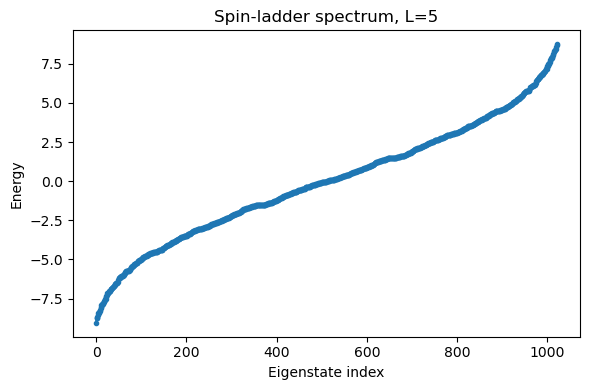

In [17]:

# Plot spectrum
plt.figure(figsize=(6,4))
plt.plot(np.arange(k_eigs), np.real(eigvals), '.-')
plt.xlabel('Eigenstate index')
plt.ylabel('Energy')
plt.title(f'Spin-ladder spectrum, L={L}')
plt.tight_layout()
plt.show()


## Single excitation subspace

In [25]:
L = 10
N_sites = 2 * L
# Build and diagonalize
H_spin = build_H_spin(L, omega_c, omega_q, g_Φ, g_c, g_q)

In [26]:
U = single_excitation_basis_matrix(N_sites)
H_single_exc_subspace = U.conj().T @ H_spin @ U

In [27]:
E, ψ = np.linalg.eigh(H_single_exc_subspace.todense())

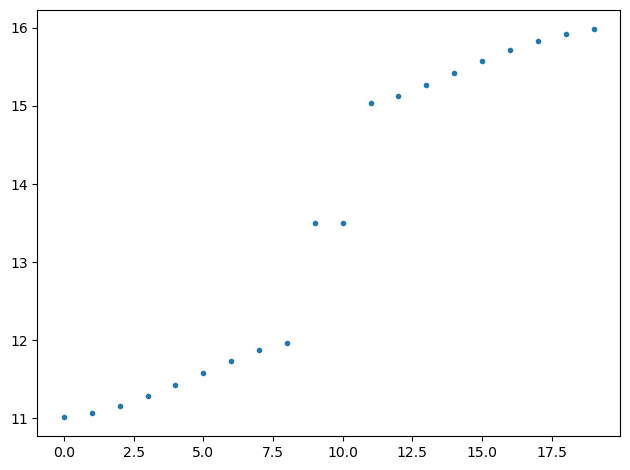

In [28]:
fig, ax = plt.subplots()

ax.plot(E,'.')

fig.tight_layout()

In [29]:
mid_index = len(E)//2
eigenvector_of_interest = ψ[:, mid_index]  # column
amplitudes_a = []
amplitudes_b = []
for n in range(L):
    amp_a_n = eigenvector_of_interest[2*n]
    amp_b_n = eigenvector_of_interest[2*n+1]
    amplitudes_a.append(np.abs(amp_a_n)**2)
    amplitudes_b.append(np.abs(amp_b_n)**2)
amplitudes_a = np.array(amplitudes_a).flatten()
amplitudes_b = np.array(amplitudes_b).flatten()


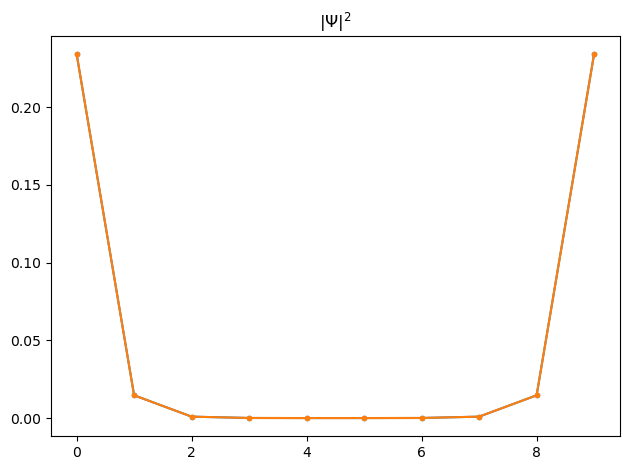

In [30]:
fig, ax = plt.subplots()

ax.plot(amplitudes_a,'.-')
ax.plot(amplitudes_b,'.-')
ax.set_title(f'$|\Psi|^2$')
fig.tight_layout()